In [2]:
#fisher matrix , 信烁
import numpy as np
import scipy.interpolate
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import subprocess
from astropy.io import fits
from subprocess import Popen, PIPE
from mpl_toolkits.mplot3d import axes3d
from numpy import cos,sin
import h5py
import json

%matplotlib inline

In [3]:
###一些参数的定义
####决定取哪些作为parameter
parN=2 #参数数目
Fmatrix=np.zeros((parN,parN))#Fisher matrix
par=np.zeros((parN,1))
par[0]=0.5 #par0是spin
par[1]=0 #par1是d1

dpar=np.zeros((parN,1)) #对参数求导取的步长
dpar=par*0.001 #这里先用0.001倍的参数值作为步长
dpar[1]=0.0002
#Observation angle, will be used to transform hbar to hTT 
PHI=0/180*np.pi  #azimuthal angle, in rad
THETA=45/180*np.pi  #latitude angle, in rad

spin=par[0]

d1=par[1]

e=0.1
p=8.25


In [4]:
def getwave(filename,THETA,PHI):
#读入文件名，和观测角，输出引力波
    try:
        index, tau,t,r,th,phi,ut,ur,uth,uphi,F_t,F_r,F_th,F_phi=np.loadtxt(filename,unpack=True)
    except:
        print(filename+'  does not exist')
        quit()

    #qseudo_flat spacetime
    x=[];
    y=[];
    z=[];
    t_tau_dot=[]
    z_tau_dot=[]
    y_tau_dot=[]
    x_tau_dot=[]
    z_t_dot=[]
    y_t_dot=[]
    x_t_dot=[]
    vr_tau_dot=[]
    vth_tau_dot=[]
    vphi_tau_dot=[]
    vx_tau_dot=[]
    vy_tau_dot=[]
    vz_tau_dot=[]
    x_t_2dot=[]
    y_t_2dot=[]
    z_t_2dot=[]


    for i in np.arange(index.size):
        x.append(r[i]*np.sin(th[i])*np.cos(phi[i]));
        y.append(r[i]*np.sin(th[i])*np.sin(phi[i]));
        z.append(r[i]*np.cos(th[i]));
        t_tau_dot.append(ut[i])
        x_tau_dot.append(ur[i]*np.sin(th[i])*np.cos(phi[i]) + r[i]*np.cos(th[i])*np.cos(phi[i])*uth[i] - r[i]*np.sin(th[i])*np.sin(phi[i])*uphi[i] )
        y_tau_dot.append(ur[i]*np.sin(th[i])*np.sin(phi[i]) + r[i]*np.cos(th[i])*np.sin(phi[i])*uth[i] + r[i]*np.sin(th[i])*np.cos(phi[i])*uphi[i] )
        z_tau_dot.append(ur[i]*np.cos(th[i]) - r[i]*np.sin(th[i])*uth[i])
        x_t_dot.append(x_tau_dot[i]/t_tau_dot[i])
        y_t_dot.append(y_tau_dot[i]/t_tau_dot[i])
        z_t_dot.append(z_tau_dot[i]/t_tau_dot[i])

        vr_tau_dot.append( (F_r[i]*t_tau_dot[i]-ur[i]*F_t[i])/t_tau_dot[i]/t_tau_dot[i] )
        vth_tau_dot.append( (F_th[i]*t_tau_dot[i]-uth[i]*F_t[i])/t_tau_dot[i]/t_tau_dot[i] )
        vphi_tau_dot.append( (F_phi[i]*t_tau_dot[i]-uphi[i]*F_t[i])/t_tau_dot[i]/t_tau_dot[i] )

        vx_tau_dot.append( vr_tau_dot[i]*np.sin(th[i])*np.cos(phi[i]) + ur[i]/ut[i]*np.cos(th[i])*np.cos(phi[i])*uth[i] - ur[i]/ut[i]*np.sin(th[i])*np.sin(phi[i])*uphi[i]\
             + ur[i]*cos(th[i])*cos(phi[i])*uth[i]/ut[i] - r[i]*sin(th[i])*cos(phi[i])*uth[i]/ut[i]*uth[i] -r[i]*cos(th[i])*sin(phi[i])*uth[i]/ut[i]*uphi[i] +r[i]*cos(th[i])*cos(phi[i])*vth_tau_dot[i]  \
             - ur[i]*sin(th[i])*sin(phi[i])*uphi[i]/ut[i] - r[i]*cos(th[i])*sin(phi[i])*uphi[i]/ut[i]*uth[i] - r[i]*sin(th[i])*cos(phi[i])*uphi[i]/ut[i]*uphi[i] - r[i]*sin(th[i])*sin(phi[i])*vphi_tau_dot[i])

        vy_tau_dot.append( vr_tau_dot[i]*np.sin(th[i])*np.sin(phi[i]) + ur[i]/ut[i]*np.cos(th[i])*np.sin(phi[i])*uth[i] + ur[i]/ut[i]*np.sin(th[i])*np.cos(phi[i])*uphi[i]\
             + ur[i]*cos(th[i])*sin(phi[i])*uth[i]/ut[i] - r[i]*sin(th[i])*sin(phi[i])*uth[i]/ut[i]*uth[i] +r[i]*cos(th[i])*cos(phi[i])*uth[i]/ut[i]*uphi[i] +r[i]*cos(th[i])*sin(phi[i])*vth_tau_dot[i]  \
             + ur[i]*sin(th[i])*cos(phi[i])*uphi[i]/ut[i] + r[i]*cos(th[i])*cos(phi[i])*uphi[i]/ut[i]*uth[i] - r[i]*sin(th[i])*sin(phi[i])*uphi[i]/ut[i]*uphi[i] + r[i]*sin(th[i])*cos(phi[i])*vphi_tau_dot[i])

        vz_tau_dot.append( vr_tau_dot[i]*cos(th[i]) -ur[i]/ut[i]*sin(th[i])*uth[i] \
                         -ur[i]*sin(th[i])*uth[i]/ut[i] -r[i]*cos(th[i])*uth[i]/ut[i]*uth[i] - r[i]*sin(th[i])*vth_tau_dot[i] )

        x_t_2dot.append(vx_tau_dot[i]/ut[i])
        y_t_2dot.append(vy_tau_dot[i]/ut[i])
        z_t_2dot.append(vz_tau_dot[i]/ut[i])

    #四极矩算法，在trace-reversed gauge的metric

    hbar_xx=[]
    hbar_yy=[]
    hbar_zz=[]
    hbar_xy=[]
    hbar_yz=[]
    hbar_xz=[]
    for i in np.arange(index.size):
        hbar_xx.append(4*(x_t_dot[i]*x_t_dot[i]+x[i]*x_t_2dot[i]))
        hbar_yy.append(4*(y_t_dot[i]*y_t_dot[i]+y[i]*y_t_2dot[i]))
        hbar_zz.append(4*(z_t_dot[i]*z_t_dot[i]+z[i]*z_t_2dot[i]))
        hbar_xy.append(2*(y[i]*x_t_2dot[i]+y_t_2dot[i]*x[i]+2*y_t_dot[i]*x_t_dot[i]))
        hbar_yz.append(2*(y[i]*z_t_2dot[i]+y_t_2dot[i]*z[i]+2*y_t_dot[i]*z_t_dot[i]))
        hbar_xz.append(2*(z[i]*x_t_2dot[i]+z_t_2dot[i]*x[i]+2*z_t_dot[i]*x_t_dot[i]))

    #由trace-reversed gauge转换到transverse traceless gauge

    hTT_TT=[]
    hTT_PP=[]
    hTT_TP=[]
    hTT_plus=[]
    hTT_cross=[]

    for i in np.arange(index.size):


        hTT_TT.append( np.cos(THETA)*np.cos(THETA)* (hbar_xx[i]*np.cos(PHI)*np.cos(PHI) + hbar_xy[i]*np.sin(2*PHI) + hbar_yy[i]*np.sin(PHI)*np.sin(PHI) )  +  hbar_zz[i]*np.sin(THETA)*np.sin(THETA)  -  np.sin(2*THETA)* (hbar_xz[i]*np.cos(PHI)+hbar_yz[i]*np.sin(PHI))  )
        hTT_TP.append( np.cos(THETA)* (-0.5*hbar_xx[i]*np.sin(2*PHI) + hbar_xy[i]*np.cos(2*PHI) + 0.5*hbar_yy[i]*np.sin(2*PHI))  +  np.sin(THETA)* (hbar_xz[i]*np.sin(PHI)-hbar_yz[i]*np.cos(PHI)) )
        hTT_PP.append( hbar_xx[i]*np.sin(PHI)*np.sin(PHI)  -  hbar_xy[i]*np.sin(2*PHI)  +  hbar_yy[i]*np.cos(PHI)*np.cos(PHI) )
        hTT_plus.append(0.5*(hTT_TT[i]-hTT_PP[i]))
        hTT_cross.append(hTT_TP[i])

    #注意上面算出来的h还要*mu（mass ratio）/R（观测距离，也以M为单位）才是真的strain
    #发现一个小问题，上面定义的数据类型大部分都是list，但是array才比较好用
    #还要注意一点几何单位制和SI单位的转换

    ########转换单位
    Grav=6.674e-11 #引力常数
    clight=2.998e8 #光速
    Msol=1.989e30  #太阳质量，以千克做单位

    M=1e6 # clight*clight*clight/Grav/Msol/1 #中心天体质量，以太阳质量为单位

    #把时间转换成秒
    t_sec=t*M*Msol*Grav/clight/clight/clight
    dt=t_sec[1]-t_sec[0]

    #把pc距离转换成M为单位
    R_pc=5e9  #以pc为单位的观测距离
    R=R_pc*3.0857e16*clight*clight/Grav/M/Msol  #以中心天体质量为单位的，长度米与中心天体质量的换算是 1m/kg = clight*clight/G

    #小天体的质量
    mu=1e-5 #应该是以中心天体质量为单位的

    hTT_plus_true=np.array(hTT_plus)*mu/R
    hTT_cross_true=np.array(hTT_cross)*mu/R

    ########用于计算的波形，plus作为实部，cross作为虚部

    return t,hTT_plus_true+hTT_cross_true*1j
    
    

In [6]:
spin=par[0]
d1=par[1]
#r0=20
#E=0.968693
#Lz=4.077016

print(e,p)

#测地线数据文件名
filename='C:\\Users\\HP\\Documents\\Visual Studio 2015\\Projects\\RK4geo8_dt\\RK4geo8_dt\\trace_spin%.6f_d1%.6f_e%.6f_p%.6f.dat'%(spin,d1,e,p)
t,basewave=getwave(filename,THETA,PHI)
dt=t[1]-t[0]

0.1 8.25


In [7]:
#参数分别变化dpar后的波形
wave=[]
for ii in np.arange(parN):
    par[ii]=par[ii]+dpar[ii]
    spin=par[0]
    d1=par[1]
    #r0=20
    #E=0.968693
    #Lz=4.077016
    
    
    filename='C:\\Users\\HP\\Documents\\Visual Studio 2015\\Projects\\RK4geo8_dt\\RK4geo8_dt\\trace_spin%.6f_d1%.6f_e%.6f_p%.6f.dat'%(spin,d1,e,p)
    print(e,p)
    t,thiswave=getwave(filename,THETA,PHI)
    wave.append(thiswave)
    par[ii]=par[ii]-dpar[ii]

0.1 8.25
0.1 8.25


D:\ProgramFiles\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'retarded time')

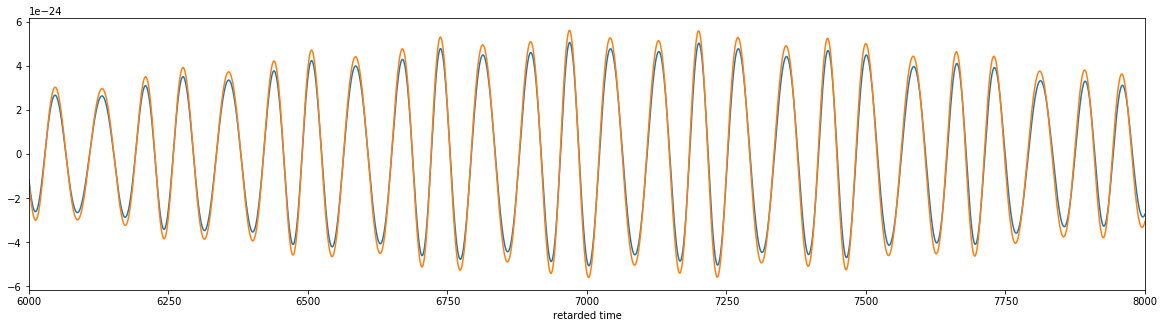

In [21]:
    
fig=plt.figure()
fig.set_size_inches(20, 5)
plt.xlim(6000,8000)
#plt.ylim(-1,1)
#plt.plot(t,basewave)
plt.plot(t,wave[0]-basewave)
plt.plot(t,(wave[1]-basewave)*4)
#plt.plot(t,np.real(mydata)*R/mu)
plt.xlabel('retarded time')

In [9]:
def bracket(mydata,mytemp,dt):

    
    #两个时间序列长度要一样
    if len(mydata) != len(mytemp):
        print("inner product: length not match!")
        return

    #采样频率
    fs=1/dt

    #做傅里叶变换，注意要除以采样频率才是真的amplitude
    mydata_fft=np.fft.fft(mydata)/fs
    mytemp_fft=np.fft.fft(mytemp)/fs
    #变换后的频率序列,注意，只有前一半是正的频率
    freq=np.fft.fftfreq(len(mydata),dt)
    
    
    ##########LISA noise, reference: https://arxiv.org/abs/gr-qc/0607007v2
    u=2*np.pi*freq*50/3 #见reference（36）上面一段
    Sn=[]  #LISA noise
    for i in np.arange(freq.size/2):
        i=int(i)
        if i==0:
            Sn.append(1e10)
        elif(u[i]<0.25):
            Sn.append(8.08e-48/((2*np.pi*freq[i])**4) +5.52e-41 )
        else :
            Sn.append( (2.88e-48/((2*np.pi*freq[i])**4) +5.52e-41 ) *u[i]*u[i]/ ( (1+cos(u[i])*cos(u[i]) )*(1.0/3.0-2.0/u[i]/u[i]) + sin(u[i])**2 + 4*sin(u[i])*cos(u[i])/(u[i]**3) ) )


    ###########SNR
    SNR=0
    #SNspec=[]
    df=freq[1]-freq[0]
    for i in np.arange(freq.size/2):
        i=int(i)
        #SNspec.append(( mydata_fft[i]*np.conjugate(mytemp_fft[i]) + np.conjugate(mydata_fft[i])*mytemp_fft[i])/(Sn[i]))
        SNR=SNR+(( mydata_fft[i]*np.conjugate(mytemp_fft[i]) + np.conjugate(mydata_fft[i])*mytemp_fft[i])/(Sn[i]))*df
    #if len(SNspec)%2 == 0 :
        #plt.loglog(freq[np.arange(int(freq.size/2))],np.abs(SNspec))
    #else:
        #plt.loglog(freq[np.arange(1+int(freq.size/2))],np.abs(SNspec))
    #plt.xlim(1e-4,1e-1)
    #plt.ylim(1e-7*np.max(np.abs(SNspec)),np.max(np.abs(SNspec)))
    #print(SNR)
    return np.abs(SNR)

In [10]:

SNR=np.sqrt(bracket(basewave,basewave,dt))
for ii in np.arange(parN):
    for jj in np.arange(parN):
        Fmatrix[ii,jj]=bracket(30/SNR*(wave[ii]-basewave)/dpar[ii],30/SNR*(wave[jj]-basewave)/dpar[jj],dt)
        #重复 PHYSICAL REVIEW D 96, 044005 (2017)，里面SNR normalized to 30


In [11]:
print(Fmatrix)

[[ 26875477.84695359  19015855.80070082]
 [ 19015855.80070082  13500590.16187192]]


In [12]:
Fmatrix=np.mat(Fmatrix)

In [13]:
Fmatrix

matrix([[ 26875477.84695359,  19015855.80070082],
        [ 19015855.80070082,  13500590.16187192]])

In [18]:
Fmatrix.I

matrix([[  1.09579156e-05,  -1.54344470e-05],
        [ -1.54344470e-05,   2.18138033e-05]])

In [17]:
SNR=np.sqrt(bracket(basewave,basewave,dt))

In [18]:
SNR

0.24653764899535408

In [19]:
30/SNR


121.68526844581592

In [26]:
np.sqrt(Fmatrix.I[0][0])

D:\ProgramFiles\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


matrix([[ 0.00096528,         nan]])